In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
from reddening_laws import *
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [2]:
dist_df = pd.read_csv('final_data_files/dist_allpoints.csv')
# fill in with zeros to conform to fit_reddening input requirements
fill_values = pd.DataFrame(np.zeros([4,7]), columns=dist_df.columns.values)
fill_values_2 = pd.DataFrame(np.zeros([1,7]), columns=dist_df.columns.values)
# show columns for reference
print dist_df.columns.values

['wavelength' 'dist_ab' 'err_ab' 'dist_c' 'err_c' 'dist_mean' 'err_mean']


In [3]:
dist_df

,wavelength,dist_ab,err_ab,dist_c,err_c,dist_mean,err_mean
0,1.220,13.858138,0.018443,13.859907,0.011767,13.859040,0.010848
1,1.630,13.819046,0.024657,13.824736,0.015373,13.821948,0.014403
2,2.190,13.805270,0.020988,13.818277,0.012680,13.811903,0.012148
3,3.550,13.791176,0.028929,13.798728,0.039489,13.795028,0.024628
4,4.493,13.761718,0.032693,13.860357,0.051777,13.812024,0.030885


In [4]:
throw_out = False
def throw_out_rrc(df):
    df.drop(df.tail(1).index, inplace=True)
    throw_out = True
    return df, throw_out

#dist_df, throw_out = throw_out_rrc(dist_df)
#print dist_df

In [5]:
def do_the_fit(dist_df, startype):
    dist_df['dist_plus2'] = dist_df['dist_' + startype] + 2*dist_df['err_' + startype]
    dist_df['dist_minus2'] = dist_df['dist_' + startype] - 2*dist_df['err_' + startype]
    dist_full_df = pd.concat([fill_values, dist_df])
    if throw_out:
        dist_full_df = pd.concat([fill_values, dist_df, fill_values_2])
    reddening_input = pd.concat([dist_full_df['dist_' + startype], dist_full_df['err_' + startype]], axis=0)
    dist, Av, dist_err, Av_err, Alam = fit_reddening(*reddening_input)
    reddening_input2 = pd.concat([dist_full_df.dist_plus2, dist_full_df['err_' + startype]], axis=0)
    dist2, Av2, dist_err2, Av_err2, Alam = fit_reddening(*reddening_input2)
    reddening_input3 = pd.concat([dist_full_df.dist_minus2, dist_full_df['err_' + startype]], axis=0)
    dist3, Av3, dist_err3, Av_err3, Alam = fit_reddening(*reddening_input3)
    return dist_df, dist, dist_err, Av, Av_err, Av2, Av3, Alam

In [6]:
startype = 'ab'
if startype=='mean':
    alpha=1.
else:
    alpha=0.3
dist_df, dist, dist_err, Av, Av_err, Av2, Av3, Alam = do_the_fit(dist_df, startype)

dist_df['u0_mean'] = dist_df.dist_mean.values - (Alam * Av)
dist_df['u0err_mean'] = np.sqrt(dist_df.err_mean.values**2 + (Alam * Av_err)**2)
dist_df['u0_ab'] = dist_df.dist_ab.values - (Alam * Av)
dist_df['u0err_ab'] = np.sqrt(dist_df.err_ab.values**2 + (Alam * Av_err)**2)
dist_df['u0_c'] = dist_df.dist_c.values - (Alam * Av)
dist_df['u0err_c'] = np.sqrt(dist_df.err_c.values**2 + (Alam * Av_err)**2)

In [7]:
# make extinction curve
nearir_x = np.linspace(1.22,1.5,50)
midir_x = np.linspace(1.5,4.5,100)

Rv = 3.1
Ak = ccm_nearir(2.164,Rv)

nearir_y = ccm_nearir(nearir_x,Rv) * Av + dist
midir_y = indebetouw_ir(midir_x) * Ak * Av + dist

nearir_y_2 = ccm_nearir(nearir_x,Rv) * Av2 + dist
midir_y_2 = indebetouw_ir(midir_x) * Ak * Av2 + dist

nearir_y_3 = ccm_nearir(nearir_x,Rv) * Av3 + dist
midir_y_3 = indebetouw_ir(midir_x) * Ak * Av3 + dist

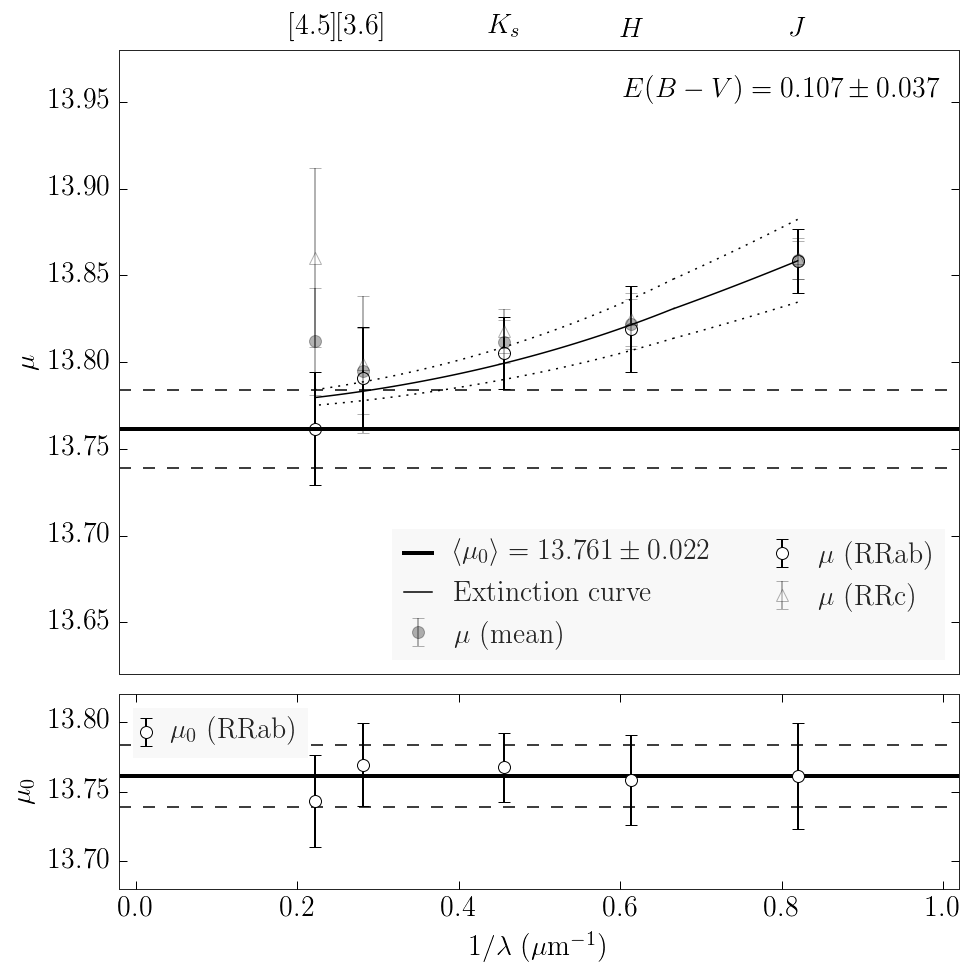

In [8]:
fig = plt.figure(figsize=(7,7))

ax = plt.subplot2grid((4,1),(0,0), rowspan=3)
ax1 = plt.subplot2grid((4,1),(3,0))
# add shadow axis object for wavelength labels
ax2 = ax.twiny()
# make line for distance modulus
x = np.linspace(-0.05,1.95,2)
y = x * 0 + dist
ax.errorbar(1/dist_df.wavelength.values, dist_df.dist_mean.values, yerr=dist_df.err_mean.values, 
            color='k', mfc='k', fmt='o', label='$\mu$ (mean)', zorder=10, alpha=alpha)
ax.errorbar(1/dist_df.wavelength.values, dist_df.dist_ab.values, yerr=dist_df.err_ab.values,
            color='k', mfc='w', fmt='o', label='$\mu$ (RRab)', zorder=0)
ax.errorbar(1/dist_df.wavelength.values, dist_df.dist_c.values, yerr=dist_df.err_c.values,
            color='k', mfc='w', fmt='^', label='$\mu$ (RRc)', zorder=0, alpha=alpha)
ppl.plot(ax, x, y, 'k-', lw=2, label=r'$\langle\mu_0\rangle = {:.3f}\pm{:.3f}$'.format(dist,dist_err))
ppl.plot(ax, x, y + dist_err, 'k--')
ppl.plot(ax, x, y - dist_err, 'k--')
ppl.plot(ax, 1/nearir_x, nearir_y, 'k-', label='Extinction curve')
ppl.plot(ax, 1/midir_x, midir_y, 'k-')
ppl.plot(ax2, 1/nearir_x, nearir_y_2, 'k:')
ppl.plot(ax, 1/midir_x, midir_y_2, 'k:')
ppl.plot(ax, 1/nearir_x, nearir_y_3, 'k:')
ppl.plot(ax, 1/midir_x, midir_y_3, 'k:')
ax.set_xlim(-0.02,1.02)
ax1.set_xlim(ax.get_xlim())
ax.set_xticks([])
ppl.legend(ax, loc=4, prop={'size':14}, numpoints=1, handlelength=1, ncol=2)
ax2.set_xlim(ax.get_xlim())
ax2.xaxis.set_ticks_position('none')
# set top tick labels to bandpasses
ax2.set_xticks(1/dist_df.wavelength)
ax2.set_xticklabels(['$J$', '$H$',  '$K_s$', '[3.6]', '[4.5]'])
ax.set_ylim(13.62,13.98)
ax.text(ax.get_xlim()[1]-0.025,ax.get_ylim()[1]-0.015,
        '$E(B-V) = {:.3f} \pm {:.3f}$'.format(Av/3.1,Av_err/3.1), ha='right',va='top')

ppl.plot(ax1, x, y, 'k-', lw=2)
ppl.plot(ax1, x, y + dist_err, 'k--')
ppl.plot(ax1, x, y - dist_err, 'k--')
if startype=='ab':
    mfc = 'w'
    label = 'RRab'
else:
    mfc = 'k'
    label = 'mean'
ax1.errorbar(1/dist_df.wavelength.values, dist_df[r'u0_{}'.format(startype)].values,
             yerr=dist_df[r'u0err_{}'.format(startype)].values, 
             color='k', mfc=mfc, fmt='o', zorder=10, label=r'$\mu_0$ ({})'.format(label))

ax1.set_xlabel(r'$1/\lambda\ (\mu\mathrm{m}^{-1})$')
ax.set_ylabel(r'$\mu$')
ax1.set_ylabel(r'$\mu_0$')
if startype=='ab':
    ax1.set_ylim(13.68,13.82)
    ax1.set_yticks(np.linspace(13.7,13.8,3))
else:
    ax1.set_ylim(13.74,13.87)
    ax1.set_yticks(np.linspace(13.75,13.85,3))
ppl.legend(ax1, loc='upper left', prop={'size':14}, numpoints=1, handlelength=0.1)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
fig.savefig('final_plots/multiwavelength_distance_allpoints_{}.pdf'.format(startype), dpi=300)

In [9]:
u0 = np.array([dist_df.wavelength, dist_df.dist_ab, dist_df.err_ab, dist_df.dist_c,
               dist_df.err_c, dist_df.dist_mean, dist_df.err_mean,
               dist_df.u0_ab, dist_df.u0err_ab, dist_df.u0_c,
               dist_df.u0err_c, dist_df.u0_mean, dist_df.u0err_mean]).T

In [10]:
for i in u0:
    strlist = [r'${:.3f} \pm {:.3f}$'.format(i[j],i[j+1]) for j in np.arange(1, len(i) / 2 + 1)*2 - 1]
    print i[0], '&', ' & '.join(strlist), r'& sigab & sigc \\'
    #print r'& ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ & ${:.3f} \pm {:.3f}$ \\'.\
    #format(i[0], i[1], i[2], i[3], i[4], i[5])

1.22 & $13.858 \pm 0.018$ & $13.860 \pm 0.012$ & $13.859 \pm 0.011$ & $13.761 \pm 0.038$ & $13.763 \pm 0.035$ & $13.762 \pm 0.035$ & sigab & sigc \\
1.63 & $13.819 \pm 0.025$ & $13.825 \pm 0.015$ & $13.822 \pm 0.014$ & $13.758 \pm 0.032$ & $13.764 \pm 0.026$ & $13.761 \pm 0.025$ & sigab & sigc \\
2.19 & $13.805 \pm 0.021$ & $13.818 \pm 0.013$ & $13.812 \pm 0.012$ & $13.767 \pm 0.025$ & $13.780 \pm 0.018$ & $13.774 \pm 0.018$ & sigab & sigc \\
3.55 & $13.791 \pm 0.029$ & $13.799 \pm 0.039$ & $13.795 \pm 0.025$ & $13.769 \pm 0.030$ & $13.777 \pm 0.040$ & $13.773 \pm 0.026$ & sigab & sigc \\
4.493 & $13.762 \pm 0.033$ & $13.860 \pm 0.052$ & $13.812 \pm 0.031$ & $13.743 \pm 0.033$ & $13.842 \pm 0.052$ & $13.794 \pm 0.032$ & sigab & sigc \\
